In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import os
import pickle
from collections import defaultdict

In [2]:
# Meta data and environment vars

COLS = ["_idx", "x_accel", "y_accel", "z_accel", "target"]
CORE_FEATURES = ["x_accel", "y_accel", "z_accel"]

TARGET_LABELS = {
    1: "Working at Computer",
    2: "Standing Up, Walking and Going updown stairs",
    3: "Standing",
    4: "Walking",
    5: "Going UpDown Stairs",
    6: "Walking and Talking with Someone",
    7: "Talking while Standing",        
}
VALID_TARGETS = list(TARGET_LABELS.keys()) # i.e: 1-7

SAMPLING_RATE = 52 #data recorded at 52HZ (aka 52 rows per second)

# Where the data lives
DATA_DIR = os.path.join(os.getcwd(), 'data')
CSV_FILES = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.csv')]

In [3]:
# Read files, keeping only feature columns and target
dfs = [pd.read_csv(f, names=COLS, usecols=CORE_FEATURES+['target']) for f in CSV_FILES]
master = pd.concat(dfs).reset_index()

In [4]:
# Ensure targets are valid values (1-7)
master_valid = master[master['target'].isin(VALID_TARGETS)]

# Alright, let's establish a baseline 
How well would a random classifier do?

In [5]:
(master_valid.groupby('target').count()['index'] / len(master_valid)).max()

0.31649036984115347

A random classifier would be right around 31.6% of the time

In [ ]:
"""
**Warning, this takes a while to run!**

2nd baseline: 

Just throw the raw features into an RF to see what we get.

Score ~0.72. Not bad. At random, we'd expect 0.32

Note: this isn't even treating the data as a time-series. 
train_test_split shuffles the data

"""

X = master_valid[CORE_FEATURES]
y = master_valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_baseline = RandomForestClassifier(n_estimators=100)
rf_baseline.fit(X_train, y_train)

y_pred = rf_baseline.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
labels = list(TARGET_LABELS.values())
sn.heatmap(conf_mat, xticklabels=labels, yticklabels=labels)

test_score = rf_baseline.score(X_test, y_test)
print("Test score: %f"%test_score)

In [6]:
# Helper functions

def window(width, overlap, max_idx):
    """
    Generates tuples of indices that define a window
    of given width and overlap. 
    
    For example:
    window(width=10, overlap=0.5, max_length=30)
    (0, 10)
    (5, 15)
    (10, 20)
    (15, 25)
    Note: it trims the end; i.e. won't return (25, 30)
    """
    start = 0
    if overlap < 0.0 or overlap >= 1.:
        raise ValueError("overlap needs to be a number between 0 and 1")
    while True:
        end = start + width
        if end >= max_idx:
            return None
        yield start, end
        start += max(int((1-overlap)*width), 1)

        
def window_df(df, width, overlap):
    """
    Applies window to a dataframe
    """
    windows = window(width, overlap, len(df))
    for start, end in windows:
        yield df[start:end]


def standardize(df):
    """
    Make the mean of data 0 with standard dev of 1
    """
    return (df - df.mean()) / df.std()


def abs_rfft( series ):
    complex_fourier = np.fft.rfft( series )
    return np.absolute(complex_fourier)

In [7]:
# Generating samples takes a few minutes.
# TODO: explore panda's rolling_window function

SAMPLE_SECONDS = 5
SAMPLE_OVERLAP = 0.5

feature_matrix = pd.DataFrame()
for target, df in master_valid.groupby('target'):
    
    # 0-center the mean and normalize. this adds about 5 points
    df[CORE_FEATURES] = standardize(df[CORE_FEATURES])
    
    new_group = defaultdict(list)
    new_group['target'] = target
    samples = window_df(df, SAMPLE_SECONDS*SAMPLING_RATE, SAMPLE_OVERLAP)
    for idx,sample in enumerate(samples):
        
        # means of amplitudes
        means = sample[CORE_FEATURES].mean()
        new_group['x_accel_mean'].append(means['x_accel'])
        new_group['y_accel_mean'].append(means['y_accel'])
        new_group['z_accel_mean'].append(means['z_accel'])
        
        # standard deviation of amplitudes
        stds = sample[CORE_FEATURES].std()
        new_group['x_accel_std'].append(stds['x_accel'])
        new_group['y_accel_std'].append(stds['y_accel'])
        new_group['z_accel_std'].append(stds['z_accel'])
        
        # max-min
        new_group['x_max_min'].append(max(sample.x_accel) - min(sample.x_accel))
        new_group['y_max_min'].append(max(sample.y_accel) - min(sample.y_accel))
        new_group['z_max_min'].append(max(sample.z_accel) - min(sample.z_accel))
        
        # xy, xz, yz correlations
        corrs = sample[CORE_FEATURES].corr()
        new_group['xy_corr'].append(corrs.loc['x_accel', 'y_accel'])
        new_group['xz_corr'].append(corrs.loc['x_accel', 'z_accel'])
        new_group['yz_corr'].append(corrs.loc['y_accel', 'z_accel'])
        
        # root-mean-square(x, y, z)
        rms = np.sqrt(np.mean(np.square(sample[CORE_FEATURES]), axis=1))
        new_group['rms_mean'].append(rms.mean())
        new_group['rms_std'].append(rms.std())

        
        # fourier transforms! 
        x_fft = abs_rfft(sample['x_accel'])
        y_fft = abs_rfft(sample['y_accel'])
        z_fft = abs_rfft(sample['z_accel'])
        
        new_group['x_fft_max'].append(x_fft.max())
        new_group['y_fft_max'].append(y_fft.max())
        new_group['z_fft_max'].append(z_fft.max())

        new_group['x_fft_min'].append(x_fft.min())
        new_group['y_fft_min'].append(y_fft.min())
        new_group['z_fft_min'].append(z_fft.min())
        
        new_group['x_fft_mean'].append(x_fft.mean())
        new_group['y_fft_mean'].append(y_fft.mean())
        new_group['z_fft_mean'].append(z_fft.mean())

        new_group['x_fft_std'].append(x_fft.std())
        new_group['y_fft_std'].append(y_fft.std())
        new_group['z_fft_std'].append(z_fft.std())
        
    feature_matrix = feature_matrix.append(pd.DataFrame(new_group))

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:2320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [8]:
X = feature_matrix.drop('target', axis=1)
y = feature_matrix['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
weights = y_train.groupby(y_train.values).count().to_dict()

Test score: 0.915793


/Applications/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


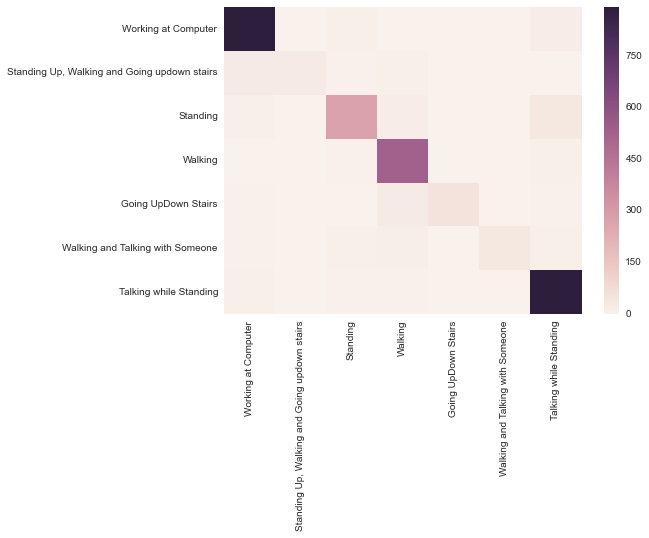

In [12]:
rf = RandomForestClassifier(class_weight=weights, n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
labels = list(TARGET_LABELS.values())
sn.heatmap(conf_mat, xticklabels=labels, yticklabels=labels)

test_score = rf.score(X_test, y_test)
print("Test score: %f"%test_score)

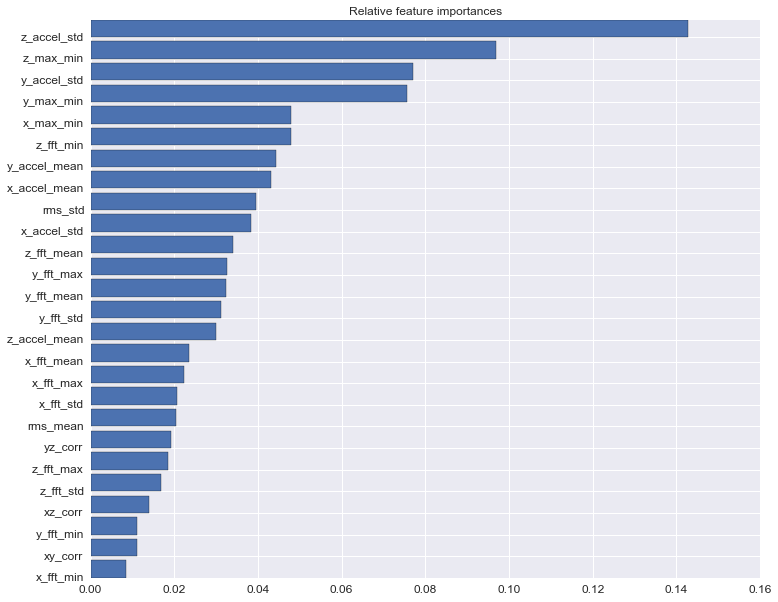

In [13]:
def plot_feature_importances(rf_model, feature_labels):
    # Features, sorted by importance:
    rf_feats = zip(rf_model.feature_importances_, feature_labels)
    rf_feats_sorted = sorted(rf_feats, key=lambda t: t[0])

    # Prepare to plot!
    x_vals = range(len(rf_feats_sorted))
    y_vals = [val for val,name in rf_feats_sorted]
    y_ticks = [name for val,name in rf_feats_sorted]
    fig = plt.figure(figsize=(12,10))
    plt.title("Relative feature importances")
    plt.tick_params(labelsize='large')
    plt.yticks(x_vals, y_ticks)
    plt.barh(bottom=x_vals,width=y_vals)

plot_feature_importances(rf, list(X.columns))

In [ ]:
with open('feature_matrix.pkl', 'wb') as f:
    pickle.dump(feature_matrix, f)

In [ ]:
test_mat = pickle.load(open('feature_matrix.pkl', 'rb'))